# Predictivity measures

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from collections import defaultdict
from itertools import pairwise

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itr import Itr
from sklearn.metrics import f1_score

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    extract_crime_data,
    random_crime_data,
)

In [15]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "HEX"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 200.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)
AREA_THRESHOLDS = [0.5, 0.25, 0.1]

In [16]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters={"Crime type": CATEGORY})
# remove any points outside boundary
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [17]:
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])

count_data = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(count_data) == len(features)

count_data

Month,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,...,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## F1 score bounds

In this context an "event" is a given spatial unit being in the set of spatial units that comprise the top $n$% of crimes.

For events occurring with probability $p$ and and a purely random (i.e. non-predictive) predictor, the normalised confusion matrix is

$$
\begin{bmatrix}
p \\
1-p
\end{bmatrix}
\otimes
\begin{bmatrix}
p \\
1-p
\end{bmatrix}
=
\begin{bmatrix}
p^2 & p(1-p) \\
p(1-p) & (1-p)^2
\end{bmatrix}
$$

The $F1$ score is given by

$$
F1 = \frac{2TP}{2TP + FP + FN}
$$

where $TP$, $FP$ and $FN$ are the number of true positives, false positives and false negatives respectively. Thus for purely random "predictions" of an event with probability $p$. Thus for a purely random confusion matrix,

$$
F1 = \frac{2p^2}{2p^2+2p(1-p)} = p
$$

For reference, both *precision* ($P = TP/(TP+FP)$) and *recall* ($R = TP/(TP+FN)$) are also equal to $p$ - $F1$ is the harmonic mean of the two. Note that true negatives (the majority of the data in our case) do not feature in the formula.

This gives us a lower bound of $p$ for the predictability of crime hotspots. A value lower than $p$ would imply effort on the perpetrators to change the locations where crimes are committed, implying some degree of premeditation. The upper bound for $p$ is 1, which would occur when the prediction is identical to the target.

Given (say) 36 months of crime data (with month temporal resolution), we take the final month as the "target", and measure its predictability against various combinations of the preceding months.


In [18]:
rng = np.random.default_rng(19937)

p = 0.2
N = 1000000

a_p = rng.choice([1, 0], p=[p, 1 - p], size=(N, 2))

confusion_matrix = np.zeros((2, 2))

for trial in a_p:
    confusion_matrix[*trial] += 1
confusion_matrix /= N


confusion_matrix - np.outer([p, 1 - p], [p, 1 - p])

print(f"independent: {f1_score(a_p[:, 0], a_p[:, 1])}")
print(f"identical: {f1_score(a_p[:, 0], a_p[:, 0])}")

independent: 0.20070963512343548
identical: 1.0


In [19]:
threshold_probs = pd.Series(index=AREA_THRESHOLDS, name="p")

for threshold in AREA_THRESHOLDS:
    threshold_probs.loc[threshold] = sum(
        ((col.sort_values().cumsum() / col.sum()) >= (1 - threshold)).mean() for _, col in count_data.items()
    ) / len(count_data.columns)

threshold_probs

0.50    0.008225
0.25    0.002547
0.10    0.000635
Name: p, dtype: float64

In [25]:
def calc_threshold_f1_impl(pred_target: pd.DataFrame, threshold: float):
    ranked = pd.concat([col.sort_values().cumsum() / col.sum() for _, col in pred_target.items()], axis=1).sort_index()

    result = ranked > 1 - threshold

    return f1_score(result.target, result.pred)


def calc_threshold_f1(count_data: pd.DataFrame) -> pd.DataFrame:
    threshold_f1 = pd.DataFrame(index=range(1, len(count_data.columns)), columns=AREA_THRESHOLDS)

    # last available month is the "target"
    target = count_data.iloc[:, -1].rename("target")
    for threshold in AREA_THRESHOLDS:
        for i in threshold_f1.index:
            pred_target = pd.concat([count_data.iloc[:, -(i + 1) : -1].mean(axis=1).rename("pred"), target], axis=1)
            threshold_f1.loc[i, threshold] = calc_threshold_f1_impl(pred_target, threshold)
    return threshold_f1


threshold_f1 = calc_threshold_f1(count_data)

In [26]:
ref_crime_data = random_crime_data(len(raw_crime_data), force_boundary, list(raw_crime_data.Month.unique()))

ref_crime_data, _ = map_to_spatial_unit(ref_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])

ref_count_data = (
    ref_crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(ref_count_data) == len(features)

ref_threshold_probs = pd.Series(index=AREA_THRESHOLDS, name="p")

for threshold in AREA_THRESHOLDS:
    ref_threshold_probs.loc[threshold] = sum(
        ((col.sort_values().cumsum() / col.sum()) >= (1 - threshold)).mean() for _, col in ref_count_data.items()
    ) / len(ref_count_data.columns)

ref_threshold_f1 = calc_threshold_f1(ref_count_data)
ref_threshold_f1

,0.50,0.25,0.10
1,0.019435,0.003906,0.0
2,0.01836,0.012388,0.009324
3,0.027505,0.016694,0.00789
4,0.030606,0.021548,0.012987
5,0.030314,0.016446,0.014085
6,0.03127,0.015727,0.007509
7,0.033594,0.019215,0.016222
8,0.037281,0.01823,0.006452
9,0.03558,0.019594,0.004065
10,0.037115,0.016308,0.003922


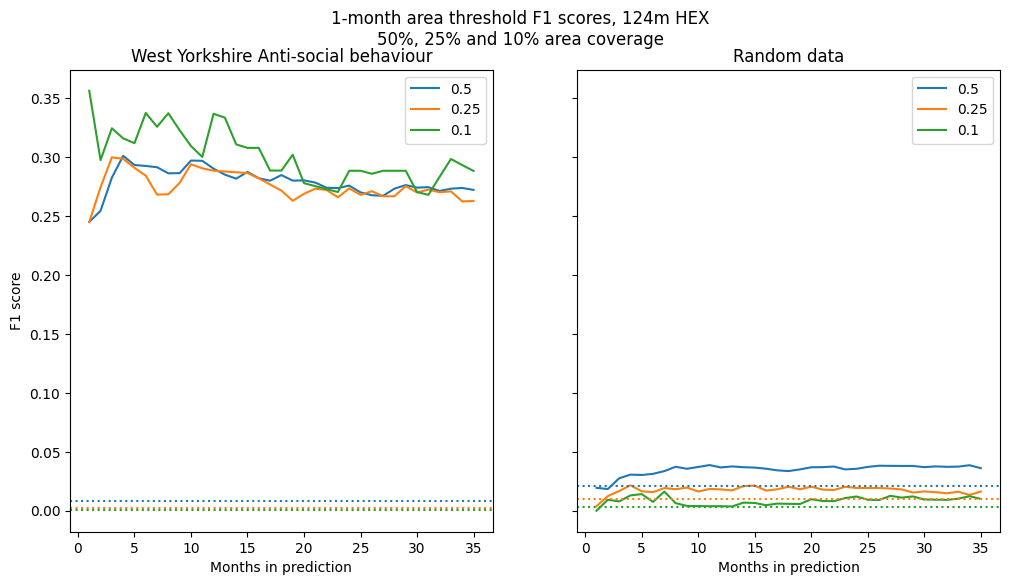

In [27]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

fig.suptitle(
    f"1-month area threshold F1 scores, {AREA_PARAMETERS[AREA]['size']:.0f}m {AREA}\n50%, 25% and 10% area coverage"
)

threshold_f1.plot(ax=axs[0], title=f"{FORCE} {CATEGORY}")
axs[0].set_xlabel("Months in prediction")
axs[0].set_ylabel("F1 score")
for i, (_, p) in enumerate(threshold_probs.items()):
    axs[0].axhline(p, ls=":", c=axs[0].lines[i].get_color())
ref_threshold_f1.plot(ax=axs[1], title="Random data")
axs[1].set_xlabel("Months in prediction")
for i, (_, p) in enumerate(ref_threshold_probs.items()):
    axs[1].axhline(p, ls=":", c=axs[1].lines[i].get_color())